In [1]:
import json
import pandas as pd
from shapely.geometry import MultiPoint, Polygon, mapping, Point
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import numpy as np


sns.set(
    {
      'figure.figsize' : (15,8)
        }
    )

In [2]:
import os
os.chdir('..')

In [3]:
!pwd

/Users/temporaryadmin/dh_projects/optimal-location-finder


In [6]:
%load_ext autoreload
%autoreload 2

from optimal_location.metrics_kpi import *

from optimal_location.utils import *
from optimal_location.aoi import generate_aoi

from connector.gcp_conn import GCSOperations

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
!pwd

/Users/temporaryadmin/dh_projects/optimal-location-finder


In [8]:

def get_input_parameters(polygon_file, warehouse_polygon_df, json_):
    driving_modes = get_drive_modes(json_)
    # driving_mode_maps = label_drive_modes(driving_modes)
    input_parameters = {
        'Number_of_stores': warehouse_polygon_df[['latitude', 'longitude']].drop_duplicates().shape[0],
        'Driving_time': int(polygon_file.split('.')[0].split('-')[-1]),
        'Driving_mode': list(driving_modes)[0], # chose 0 for cycle and 1 for driving
        'City_ID': polygon_file.split('.')[0].split('-')[-5]
    }

    return input_parameters

def save_kpis(input_params, business_kpis):
    bucket_name = "qc-store-growth-expansion-stg"
    domain = 'DS_exploration'
    project_name = 'optimal_location_finder'
    folder = 'metrics'
    region = 'FP_SG'
    path_to_save = f'gs://{bucket_name}/{domain}/{project_name}/{folder}/{region}'
    runtime = get_current_time()
    region, no_of_clusters, drive_time_selected, drive_mode_selected = input_params['City_ID'], \
                                                                       input_params['Number_of_stores'], \
                                                                       input_params['Driving_time'], \
                                                                       input_params['Driving_mode']

    filename = f'{region}_{no_of_clusters}_{drive_mode_selected}_1-{drive_time_selected}_{runtime}_{folder}.csv'
    try:
        business_kpis.to_csv(f'{path_to_save}/{filename}')
        return f'{path_to_save}/{filename}'
    except Exception as ex:
        return str(ex)


def get_order_data():
    # query = get_order_query(city_id, start_date, end_date, round_off)
    # queried_result = bigquery_conn.execute_query(query)
    bucket_name = "qc-store-growth-expansion-stg"
    domain = 'DS_exploration'
    project_name = 'optimal_location_finder'
    folder = 'evaluation'
    file_name = 'cluster_data_created_only_restaurant_11_11_2021.csv'
    region = 'FP_SG'

    path_to_file = f'gs://{bucket_name}/{domain}/{project_name}/{folder}/{region}/{file_name}'
    queried_order_info = pd.read_csv(path_to_file)

    return queried_order_info


def get_order_query(city_id, start_date, end_date, round_off=4):

    metrics_query = f"""

        SELECT store_type_l2,
        ROUND(delivery_location.latitude, {round_off}) lat,
        ROUND(delivery_location.longitude, {round_off}) long,
        COUNT(distinct analytical_customer_id) num_customers,
        COUNT(1) num_orders,
        SUM(i.quantity) num_items,
        SUM(value.gmv_local) gmv
        FROM `fulfillment-dwh-production.curated_data_shared_central_dwh.orders` o, UNNEST(items) AS i
        LEFT JOIN `fulfillment-dwh-production.curated_data_shared_central_dwh.vendors` USING(vendor_id)
        WHERE o.global_entity_id = '{city_id}'
        AND DATE(placed_at) BETWEEN '{start_date}' AND '{end_date}'
        AND order_status = 'sent'
        AND o.is_own_delivery
        AND store_type_l2 in ('restaurants')
        AND delivery_location.latitude IS NOT NULL
        AND delivery_location.longitude IS NOT NULL
        GROUP BY 1, 2, 3

    """

    return metrics_query


In [9]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../cred/credentials.json'

gcs_conn = GCSOperations("qc-store-growth-expansion-stg")
bucket_name = "qc-store-growth-expansion-stg"

folder_name = 'existing_dmart_bucket'
polygon_file = 'dmart-polygon-FP_SG-drive-time-4-15.json'
path_for_polygon = f'gs://{bucket_name}/{folder_name}/{polygon_file}'
path_for_polygon


'gs://qc-store-growth-expansion-stg/existing_dmart_bucket/dmart-polygon-FP_SG-drive-time-4-15.json'

In [10]:
!pwd

/Users/temporaryadmin/dh_projects/optimal-location-finder


In [11]:
json_ = get_polygons_for_locations(path_for_polygon)

In [12]:

warehouse_polygon_df = convert_json_to_dataframe(json_)
input_params = get_input_parameters(path_for_polygon, warehouse_polygon_df, json_)
input_params

{'Number_of_stores': 15,
 'Driving_time': 15,
 'Driving_mode': 'driving',
 'City_ID': 'FP_SG'}

In [13]:
queried_order_info = get_order_data()

In [14]:
drive_time_selected = 7

In [30]:

drive_mode_selected = input_params['Driving_mode']
drive_time_selected = 15

polygons_based_on_driving = warehouse_polygon_df[
                                                 (warehouse_polygon_df['driving_mode'] == drive_mode_selected) 
                                                 & (warehouse_polygon_df['driving_time'] <= drive_time_selected) 
                                                    & (warehouse_polygon_df['driving_time'] > 3
                                                      ) 
]
drive_mode_selected,drive_time_selected

('driving', 15)

In [32]:
%%time
constrained_locations_nested = generate_constraint_based_info(queried_order_info,
                                                                                                polygons_based_on_driving)

CPU times: user 3min 48s, sys: 7.31 s, total: 3min 55s
Wall time: 3min 55s


In [33]:
constrained_locations_unnest = get_unnested_data(constrained_locations_nested)

In [34]:
constrained_locations_nested['driving_time'].unique()

array([ 5,  7, 10, 15])

In [65]:
drive_time_selected = 5

In [66]:

locations_matching_constraints_of_T_min_drive_time = constrained_locations_unnest[
                                                     constrained_locations_unnest['driving_time']==drive_time_selected
                                                    ]

In [67]:
# Converting lat long into a tuple to be set as index 
queried_order_info['lat_long'] = list(
    zip(
        queried_order_info['lat'],
        queried_order_info['long']
    )
    )
    
locations_matching_constraints_of_T_min_drive_time['lat_long'] = list(
    zip(
        locations_matching_constraints_of_T_min_drive_time['lat'],
        locations_matching_constraints_of_T_min_drive_time['long']
    )
    )

In [68]:
# queried_order_info.set_index(['lat','long'],inplace = True)
locations_matching_constraints_of_T_min_drive_time.set_index(['lat','long'],inplace = True)

In [69]:
area_of_interest = generate_aoi( 
                                queried_order_info, 
                                locations_matching_constraints_of_T_min_drive_time)

In [70]:
area_of_interest.reset_index(inplace = True)
locations_matching_constraints_of_T_min_drive_time.reset_index(inplace = True)
queried_order_info.reset_index(inplace = True)
area_of_interest.head(4)

,lat_long,lat,long,Unnamed: 0,store_type_l2,num_customers,num_orders,num_items,gmv
0,"(1.3098, 103.836)",1.3098,103.8360,0,restaurants,2,362,389,7560.56
1,"(1.3122, 103.896)",1.3122,103.8960,1,restaurants,37,2346,2700,62872.60
2,"(1.4318, 103.7751)",1.4318,103.7751,2,restaurants,8,299,326,5378.24
3,"(1.3767, 103.8824)",1.3767,103.8824,3,restaurants,38,1335,1464,29663.68


## AOI and Existing COverage ViZ

Text(0, 0.5, 'Latitude')

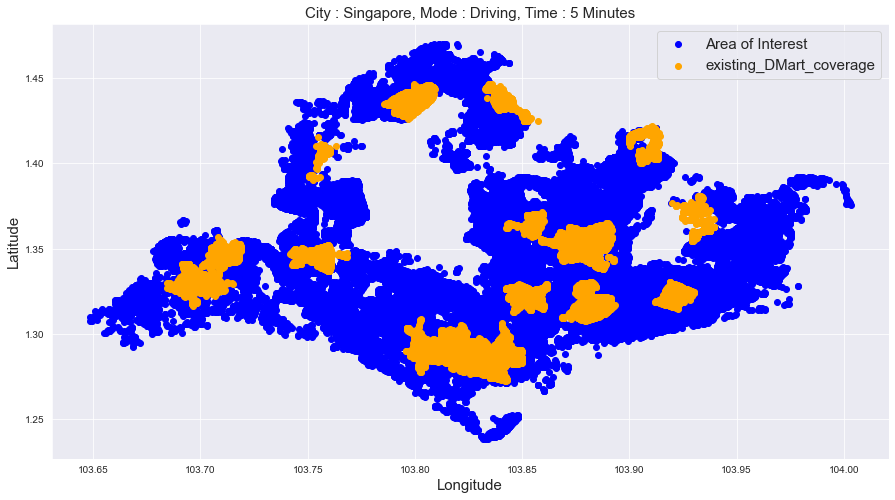

In [71]:

dmart_covered_locations = pd.DataFrame(locations_matching_constraints_of_T_min_drive_time['lat_long'].to_list(),columns = ['lat','long'])

aoi_ = plt.scatter(area_of_interest['long'],area_of_interest['lat'],color='blue')
existing_coverage = plt.scatter(dmart_covered_locations['long'],
                     dmart_covered_locations['lat'],color='orange'
                    )
plt.legend(
    (aoi_,existing_coverage),
    ('Area of Interest','existing_DMart_coverage'),
    prop={'size': 15}
    
)
plt.title(f"City : Singapore, Mode : Driving, Time : {drive_time_selected} Minutes",fontsize = 15)
plt.xlabel("Longitude",fontsize = 15)
plt.ylabel("Latitude",fontsize = 15)

Text(0, 0.5, 'Latitude')

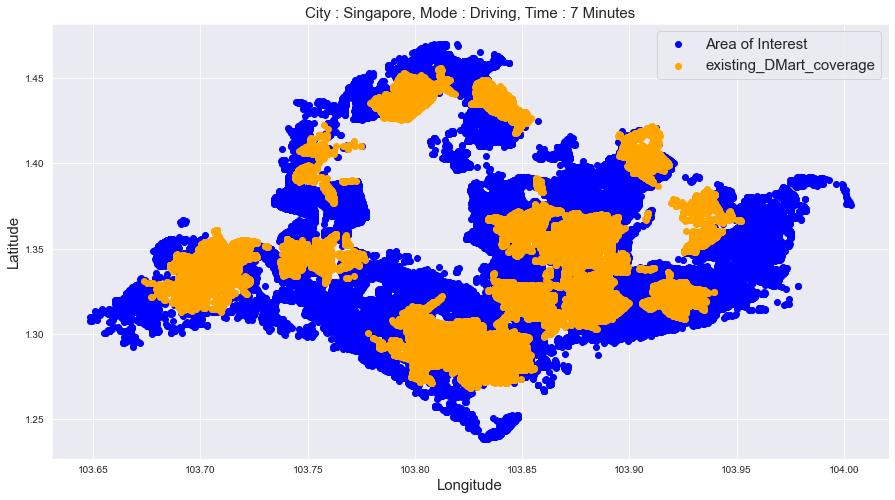

In [57]:

dmart_covered_locations = pd.DataFrame(locations_matching_constraints_of_T_min_drive_time['lat_long'].to_list(),columns = ['lat','long'])

aoi_ = plt.scatter(area_of_interest['long'],area_of_interest['lat'],color='blue')
existing_coverage = plt.scatter(dmart_covered_locations['long'],
                     dmart_covered_locations['lat'],color='orange'
                    )
plt.legend(
    (aoi_,existing_coverage),
    ('Area of Interest','existing_DMart_coverage'),
    prop={'size': 15}
    
)
plt.title(f"City : Singapore, Mode : Driving, Time : {drive_time_selected} Minutes",fontsize = 15)
plt.xlabel("Longitude",fontsize = 15)
plt.ylabel("Latitude",fontsize = 15)

Text(0, 0.5, 'Latitude')

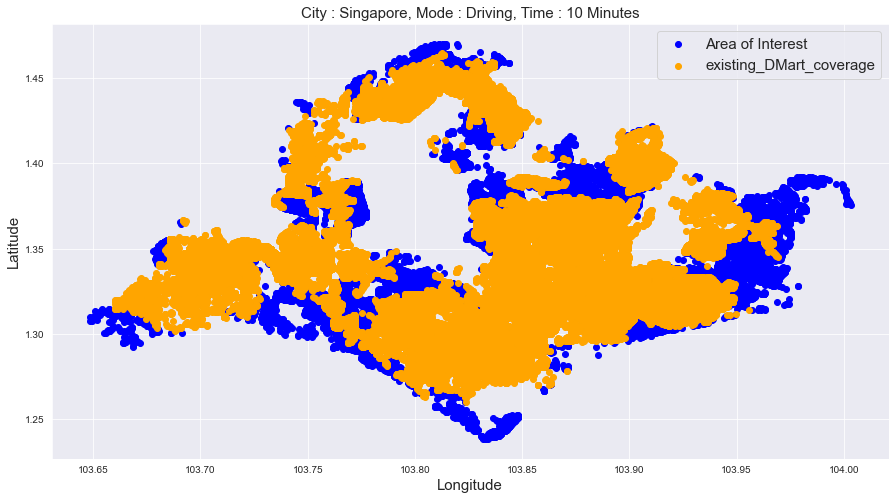

In [64]:

dmart_covered_locations = pd.DataFrame(locations_matching_constraints_of_T_min_drive_time['lat_long'].to_list(),columns = ['lat','long'])

aoi_ = plt.scatter(area_of_interest['long'],area_of_interest['lat'],color='blue')
existing_coverage = plt.scatter(dmart_covered_locations['long'],
                     dmart_covered_locations['lat'],color='orange'
                    )
plt.legend(
    (aoi_,existing_coverage),
    ('Area of Interest','existing_DMart_coverage'),
    prop={'size': 15}
    
)
plt.title(f"City : Singapore, Mode : Driving, Time : {drive_time_selected} Minutes",fontsize = 15)
plt.xlabel("Longitude",fontsize = 15)
plt.ylabel("Latitude",fontsize = 15)

In [ ]:
INPUT_PARAMETERS

## Building the Model

In [ ]:
expected_no_clusters = INPUT_PARAMETERS['Number_of_stores']

In [ ]:
grouped = area_of_interest.groupby(by=['lat', 'long']).sum().reset_index()

x = grouped[['lat', 'long']]
y = grouped['num_customers']

In [ ]:
kmeans = KMeans(n_clusters= expected_no_clusters, random_state=0, max_iter=10)

In [ ]:
wt_kmeansclus = kmeans.fit(x, sample_weight = y)

In [ ]:
proposed_warhouse_locations = pd.DataFrame(kmeans.cluster_centers_,columns=['lat','long'])

In [ ]:
existing_warehouse = dmart_coverage_locations[['pred_lat','pred_long']].drop_duplicates()

### AOI Optimal Locations

In [ ]:
import seaborn as sns

aoi_ = plt.scatter(area_of_interest['long'],area_of_interest['lat'],color='blue')
proposed_location_ = plt.scatter(proposed_warhouse_locations['long'],
                                 proposed_warhouse_locations['lat'],
                                    color='red',
                                    marker='o',
                                    s=200
                    )


plt.legend(
    (aoi_,proposed_location_),
    ('Area of Interest','opitmal_locations'),
    prop={'size': 15}
    
)
plt.title("City : Singapore, Mode : Driving, Time : 5 Minutes",fontsize = 15)
plt.xlabel("Longitude",fontsize = 15)
plt.ylabel("Latitude",fontsize = 15)

### Looking at all the Locations over the DH network

In [ ]:

aoi_ = plt.scatter(area_of_interest['long'],area_of_interest['lat'],color='blue')

network_=  plt.scatter(queried_order_info['long'],queried_order_info['lat'],color='blue')



proposed_location_ = plt.scatter(proposed_warhouse_locations['long'],
                                 proposed_warhouse_locations['lat'],
                                    color='red',
                                    marker='o',
                                    s=200
                    )

existing_location_ = plt.scatter(existing_warehouse['pred_long'],
                                 existing_warehouse['pred_lat'],
                                    color='green',
                                    marker='o',
                                    s=200
                    )


plt.legend(
    (proposed_location_,network_,existing_location_),
    ('Optimal Locations','DH network','Existing DMarts'),
    prop={'size': 15}
    
)
plt.title("City : Singapore",fontsize = 15)
plt.xlabel("Longitude",fontsize = 15)
plt.ylabel("Latitude",fontsize = 15)